# Notes

- Ugh, we do have a confound in that the validation information is also coming from bad users... hmm.

# Imports

In [125]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Utility functions

In [334]:
map_marker_to_desc = {
    ".":"point",
    ",":"pixel",
    "o":"circle",
    "v":"triangle_down",
    "^":"triangle_up",
    "<":"triangle_left",
    ">":"triangle_right",
    "1":"tri_down",
    "2":"tri_up",
    "3":"tri_left",
    "4":"tri_right",
    "8":"octagon",
    "s":"square",
    "p":"pentagon",
    "*":"star",
    "h":"hexagon1",
    "H":"hexagon2",
    "+":"plus",
    "D":"diamond",
    "d":"thin_diamond",
    "|":"vline",
    "_":"hline"
}

plot_markers = ['o','v','^','<','>','s','p','P','*','h','X','D','d','|','_',0,1,2,3,4,5,6,7,8,9,10,'1','2','3','4',',']

map_group_to_marker = {'Anonymous':'o', 'Registered':'v', 'Researcher':'s', 'Turker':'*'}

def display_overview(df):
    grouped_by_role = df.groupby('role')

    df_result = grouped_by_role['audit_mission_count', 'meters_audited', 'labels_total','validations_received_count'].sum()
    df_result['num_users'] = grouped_by_role['role'].count()

    # reorder cols: https://stackoverflow.com/a/13148611
    cols = df_result.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    df_result = df_result[cols]
    df_result['Avg Accuracy'] = grouped_by_role['accuracy'].mean()
    df_result['Med Accuracy'] = grouped_by_role['accuracy'].median()
    df_result['SD Accuracy'] = grouped_by_role['accuracy'].std()
    df_result.loc['Total'] = df_result.sum()
    
    int_cols = ['num_users', 'audit_mission_count', 'labels_total','validations_received_count']
    for col_name in int_cols:
        df_result[col_name] = df_result[col_name].astype(int)
    
    df_result.at['Total', 'Avg Accuracy'] = df['accuracy'].mean()
    df_result.at['Total', 'Med Accuracy'] = df['accuracy'].median()
    df_result.at['Total', 'SD Accuracy'] = df['accuracy'].std()
    
    #df_result2['meters_audited'] = df_result['meters_audited']
    display(df_result)

def plot_scatter(df, xcol_name, ycol_name, xlabel=None, ylabel=None, 
                 map_group_to_marker = map_group_to_marker, xlim = None, ax = None):
    groups = df.groupby('role')

    if ax is None:
        fig, ax = plt.subplots(figsize=(15,8))
    #ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling

    for name, group in groups:
        pairwise_corr = group[xcol_name].corr(group[ycol_name], method='pearson')
        #print(f"Corr of {xcol_name} to {ycol_name}: {cor}")
        ax.plot(group[xcol_name], group[ycol_name], marker=map_group_to_marker[name], 
                linestyle='', ms=10, alpha=0.65, label=f"{name} (r={pairwise_corr:0.2f})")
    ax.legend()
    
    if xlabel is None:
        xlabel = xcol_name
        
    if ylabel is None:
        ylabel = ycol_name
    
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    
    ax.set_title(f"{xlabel} vs. {ylabel}")
    
    if xlim is not None:
        ax.set_xlim(xlim)
    #plt.show()
    return ax

# Read in data

In [335]:
%%time
df_users = pd.read_csv('data/ml-seattle-stats.csv') 
df_users.rename(columns = {'validation_count':'validations_received_count'}, inplace = True) 

print(f"Read in {len(df_users)} users")
#display(df_users.groupby('role')['role', 'high_quality_manual'].count())
display_overview(df_users)

Read in 661 users


,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,288,304,6.076213e+04,3662,3611,73.672963,76.457307,25.612715
Registered,165,2125,5.725144e+05,26370,18433,69.993895,72.072072,18.518940
Researcher,9,169,4.463795e+04,3716,5598,75.145942,77.653004,14.703425
Turker,199,2998,8.590935e+05,53751,25705,63.084565,67.741935,28.826845
Total,661,5596,1.537008e+06,87499,53347,69.586911,72.727273,25.355407


Wall time: 198 ms


## Data cleansing and processing

In [400]:
# make a copy of the original DataFrame just in case we need it. We'll save
# the cleaned one in the original df_users DataFrame
df_users_original = df_users.copy()

# Remove users who have audited < 0 meters
print(f"The following indices have meters_audited < 0: {df_users[df_users.meters_audited < 0].index}")
df_users.drop(df_users[df_users.meters_audited < 0].index, inplace=True)

# Remove users who have not finished a mission
query_result = df_users[df_users.audit_mission_count <= 0]
num_users_who_never_finished_a_mission = len(query_result)
print("{}/{} users ({:0.1f}%) never completed even one mission. Removing them from analysis.".format(
    num_users_who_never_finished_a_mission, len(df_users),
    num_users_who_never_finished_a_mission / len(df_users) * 100))
df_users.drop(query_result.index, inplace=True)

min_validations_rcvd_threshold = 10
query_result = df_users[df_users.validations_received_count <= min_validations_rcvd_threshold]
num_users_without_min_validations_rcvd = len(query_result)
print("{}/{} users ({:0.1f}%) have not received the min num of validations ({}). Removing them from analysis.".format(
    num_users_without_min_validations_rcvd, len(df_users), 
    num_users_without_min_validations_rcvd / len(df_users) * 100, min_validations_rcvd_threshold))
df_users.drop(query_result.index, inplace=True)

# add in labels per meter
df_users['labels_per_meter'] = df_users['labels_total'] / df_users['meters_audited']

# Replace np.nan, np.inf, -np.inf
df_users['labels_per_meter'].replace([np.nan, np.inf, -np.inf], 0, inplace=True)

# convert high quality column to boolean
df_users['high_quality_manual'].replace(['f'], False, inplace=True)
df_users['high_quality_manual'].replace(['t'], True, inplace=True)
df_users['high_quality_manual'] = df_users['high_quality_manual'].astype('bool')

# add in percentage of labels that have severity
df_users['labels_with_severity_fraction'] = df_users['labels_with_severity'] / df_users['labels_total']
df_users['curb_ramps_with_severity_fraction'] = df_users['curb_ramps_with_severity'] / df_users['curb_ramps_total']
df_users['missing_curb_ramps_with_severity_fraction'] = df_users['missing_curb_ramps_with_severity'] / df_users['missing_curb_ramps_total']
df_users['obstacles_with_severity_fraction'] = df_users['obstacles_with_severity'] / df_users['obstacles_total']
df_users['surface_problems_with_severity_fraction'] = df_users['surface_problems_with_severity'] / df_users['surface_problems_total']
df_users['no_sidewalks_with_severity_fraction'] = df_users['no_sidewalks_with_severity'] / df_users['no_sidewalks_total']

# Replace NaN with the mean of the respective columns
df_users.fillna(df_users.mean(), inplace=True)


The following indices have meters_audited < 0: Int64Index([], dtype='int64')
0/386 users (0.0%) never completed even one mission. Removing them from analysis.
0/386 users (0.0%) have not received the min num of validations (10). Removing them from analysis.


In [401]:
#display(df_users.groupby('role')['audit_mission_count', 'meters_audited', 'labels_total'].sum())
display_overview(df_users)

,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,112,189,3.358506e+04,2550,2612,71.083496,72.570533,17.910976
Registered,146,2102,5.682522e+05,26188,18338,69.539333,71.428571,15.582016
Researcher,7,168,4.441770e+04,3699,5576,75.187639,77.653004,8.939341
Turker,121,2911,8.379271e+05,53179,25198,69.080151,72.093023,20.808297
Total,386,5370,1.484182e+06,85616,51724,69.945870,72.073676,17.925156


In [402]:
df_users.groupby('high_quality_manual')['role'].count()

high_quality_manual
False     47
True     339
Name: role, dtype: int64

In [403]:
df_users.sample(5)

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,surface_problems_with_severity,no_sidewalks_total,no_sidewalks_with_severity,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction
269,6ebbc1d4-ddb9-4232-a41d-0bbf74dc44e1,Anonymous,28,64.285714,1,2,True,152.399994,27,25,...,5,0,0,0.177165,0.925926,1.000000,0.866667,1.000000,1.000000,0.899493
286,7308d08c-8c4f-492c-9e31-eb28ffdeddc4,Anonymous,12,33.333333,1,0,True,152.399994,13,13,...,0,5,5,0.085302,1.000000,1.000000,0.933495,1.000000,0.894516,1.000000
428,a512d90a-b5b4-4172-88c8-4106805800ff,Turker,56,82.142857,5,0,True,1289.727081,95,90,...,5,14,14,0.073659,0.947368,0.985507,1.000000,0.905442,0.555556,1.000000
173,441fee65-efc0-4162-8f57-bfd0f31b9ef1,Anonymous,12,41.666667,1,3,True,152.399994,12,12,...,2,2,2,0.078740,1.000000,1.000000,1.000000,0.905442,1.000000,1.000000
373,939b6faa-0b57-4160-bcc2-d11fd2b69d9f,Registered,376,66.223404,30,3,True,8312.437523,479,465,...,44,136,133,0.057624,0.970772,0.975410,1.000000,1.000000,1.000000,0.977941


# Exploratory analysis

In [404]:
df_users.groupby('role').describe()

validations_received_count                                       \
                                count        mean         std   min    25%   
role                                                                         
Anonymous                       112.0   23.321429   14.919734  11.0  13.75   
Registered                      146.0  125.602740  302.976327  11.0  27.00   
Researcher                        7.0  796.571429  773.249605  20.0  74.50   
Turker                          121.0  208.247934  554.843436  11.0  17.00   

                                  accuracy             ...  \
              50%     75%     max    count       mean  ...   
role                                                   ...   
Anonymous    20.0    27.0   116.0    112.0  71.083496  ...   
Registered   55.5   107.5  2921.0    146.0  69.539333  ...   
Researcher  757.0  1434.5  1781.0      7.0  75.187639  ...   
Turker       25.0    47.0  3628.0    121.0  69.080151  ...   

           surface_problems_with_severity_fraction       \
                                               75%  max   
role                                                      
Anonymous                                 1.000000  1.0   
Registered                                1.000000  1.0   
Researcher                                0.995951  1.0   
Turker                                    1.000000  1.0   

           no_sidewalks_with_severity_fraction                                \
                                         count      mean       std       min   
role                                                                           
Anonymous                                112.0  0.908760  0.110887  0.187500   
Registered                               146.0  0.901237  0.184971  0.000000   
Researcher                                 7.0  0.836985  0.342555  0.063636   
Turker                                   121.0  0.892428  0.187140  0.000000   

                                               
                 25%       50%       75%  max  
role                                           
Anonymous   0.899493  0.899493  1.000000  1.0  
Registered  0.899493  0.899493  1.000000  1.0  
Researcher  0.930516  0.964539  0.984845  1.0  
Turker      0.899493  0.899493  1.000000  1.0  

[4 rows x 192 columns]

In [405]:
display(df_users.sort_values(by=['labels_per_meter'], ascending=False).head(5))

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,surface_problems_with_severity,no_sidewalks_total,no_sidewalks_with_severity,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction
525,cca9938d-dfbd-4693-9be9-071e3330e6b5,Anonymous,18,55.555556,1,3,True,10.050847,39,38,...,0,28,28,3.880270,0.974359,0.954988,1.000000,0.800000,0.894516,1.000000
655,fdab54f3-436d-404d-bdd6-455e9afd3e53,Anonymous,32,37.500000,1,0,True,152.399994,54,52,...,4,29,29,0.354331,0.962963,0.954988,0.933495,0.904762,1.000000,1.000000
309,7bc8e0d3-e465-420d-9983-82252eb1e029,Registered,64,45.312500,2,0,True,235.068642,83,74,...,19,6,6,0.353088,0.891566,0.942308,0.933495,0.905442,0.904762,1.000000
271,6eec69c1-7317-4455-b031-11412de34b46,Anonymous,12,91.666667,1,3,True,41.603485,11,10,...,0,0,0,0.264401,0.909091,1.000000,0.000000,1.000000,0.894516,0.899493
333,845e3e48-ea54-4c41-822d-8a40083014aa,Anonymous,23,39.130435,1,3,True,81.002487,21,21,...,0,0,0,0.259251,1.000000,1.000000,0.933495,1.000000,0.894516,0.899493


In [406]:
display(df_users.sort_values(by=['accuracy', 'labels_per_meter'], ascending=False).head(5))

,user_id,role,validations_received_count,accuracy,audit_mission_count,validation_mission_count,high_quality_manual,meters_audited,labels_total,labels_with_severity,...,surface_problems_with_severity,no_sidewalks_total,no_sidewalks_with_severity,labels_per_meter,labels_with_severity_fraction,curb_ramps_with_severity_fraction,missing_curb_ramps_with_severity_fraction,obstacles_with_severity_fraction,surface_problems_with_severity_fraction,no_sidewalks_with_severity_fraction
479,b6cfb689-324a-4d27-8e0e-7a98c543936c,Registered,21,100.0,1,0,True,152.399994,26,26,...,1,0,0,0.170604,1.000000,1.0,1.000000,0.905442,1.000000,0.899493
395,9ab48ccd-8a95-4a4b-a0dc-90e1e7d709b6,Anonymous,12,100.0,1,0,True,152.399994,16,16,...,0,1,1,0.104987,1.000000,1.0,0.933495,0.905442,0.894516,1.000000
117,2f6415e5-f851-4105-afc8-d2fb5f60fc77,Registered,13,100.0,1,4,True,152.399994,14,14,...,0,1,1,0.091864,1.000000,1.0,1.000000,0.905442,0.894516,1.000000
363,8fe32410-fafd-4557-91bd-c4bdb7180be0,Anonymous,16,100.0,1,0,True,152.399994,14,12,...,0,0,0,0.091864,0.857143,1.0,0.500000,0.000000,0.894516,0.899493
351,8a84d5e0-2193-4fb3-877e-0a7cc38fe47c,Anonymous,19,100.0,1,1,True,152.399994,13,13,...,1,0,0,0.085302,1.000000,1.0,1.000000,0.905442,1.000000,0.899493


## Scatter plots of features

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


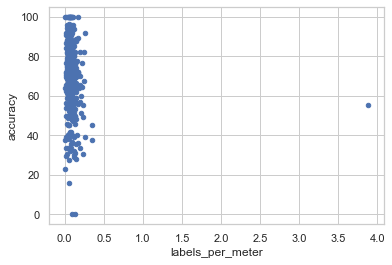

In [407]:
# We can use Pandas to create a scatter plot directly but hard to color by user group
ax = df_users.plot.scatter(x='labels_per_meter', y='accuracy')

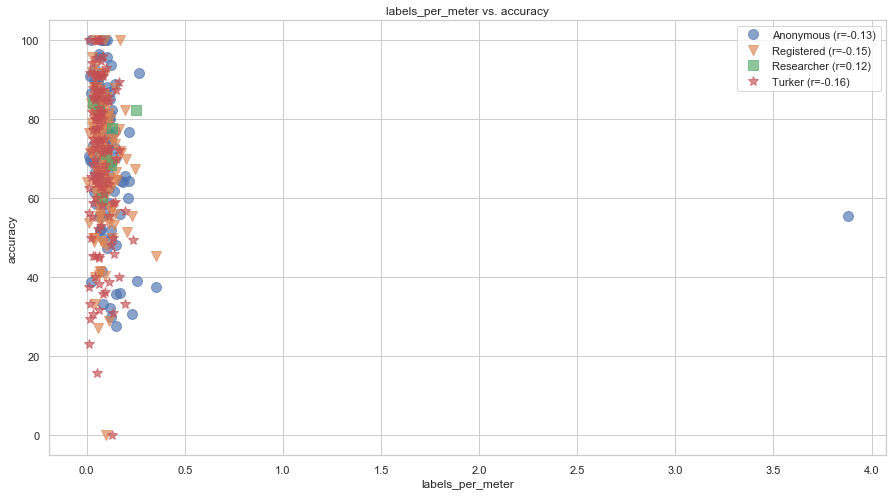

In [408]:
# So I made my own scatter plot. Let's look at the relationship between labels_per_meter and accuracy
plot_scatter(df_users, 'labels_per_meter', 'accuracy');

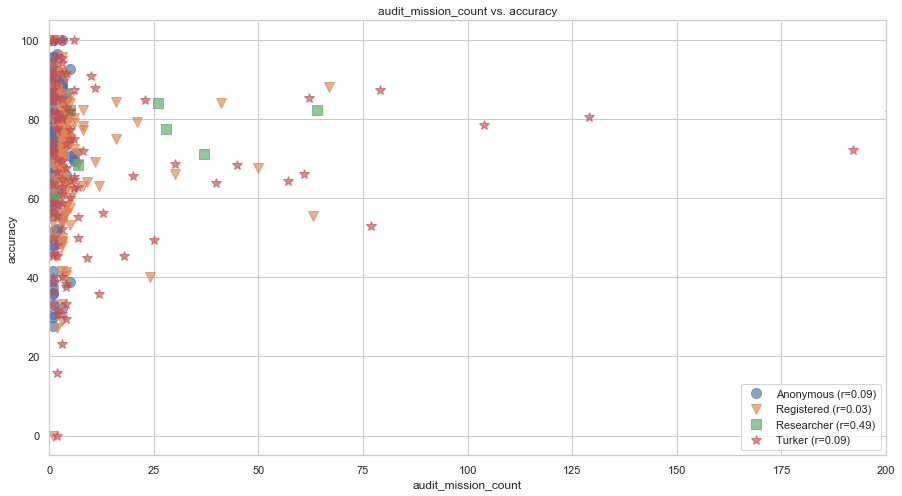

In [409]:
plot_scatter(df_users, 'audit_mission_count', 'accuracy', xlim=(0, 200));

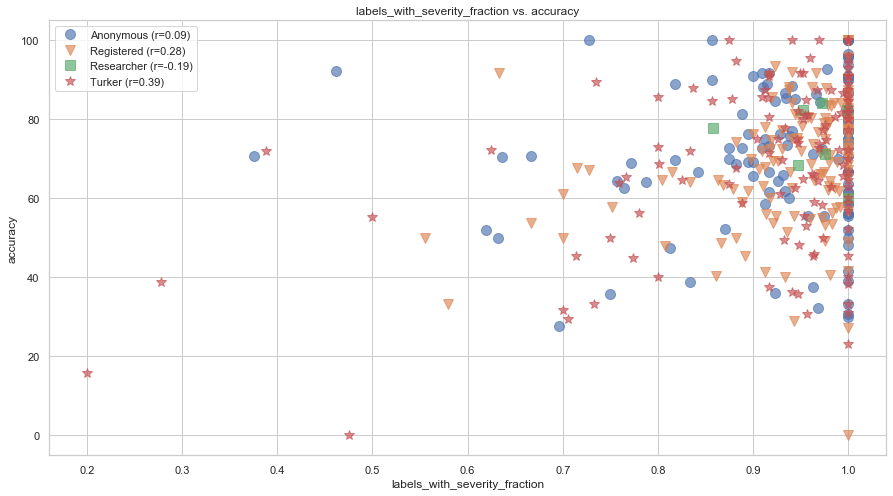

In [410]:
plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy');

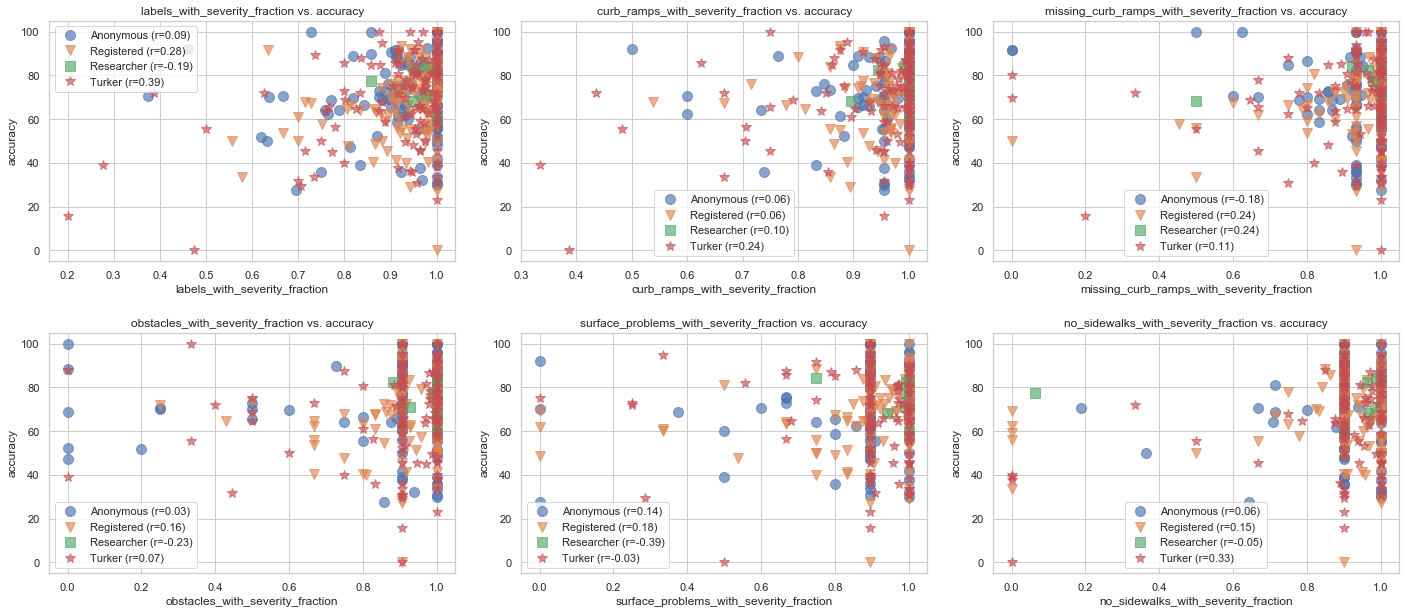

In [411]:
fig, axes = plt.subplots(2, 3, figsize=(20, 9))

plot_scatter(df_users, 'labels_with_severity_fraction', 'accuracy', ax = axes[0][0])
plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])
plt.tight_layout(pad=2)

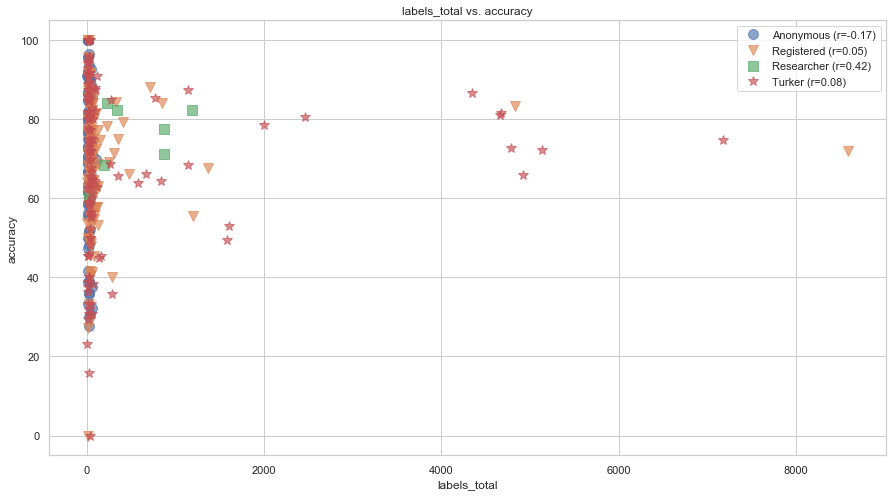

In [412]:
plot_scatter(df_users, 'labels_total', 'accuracy');

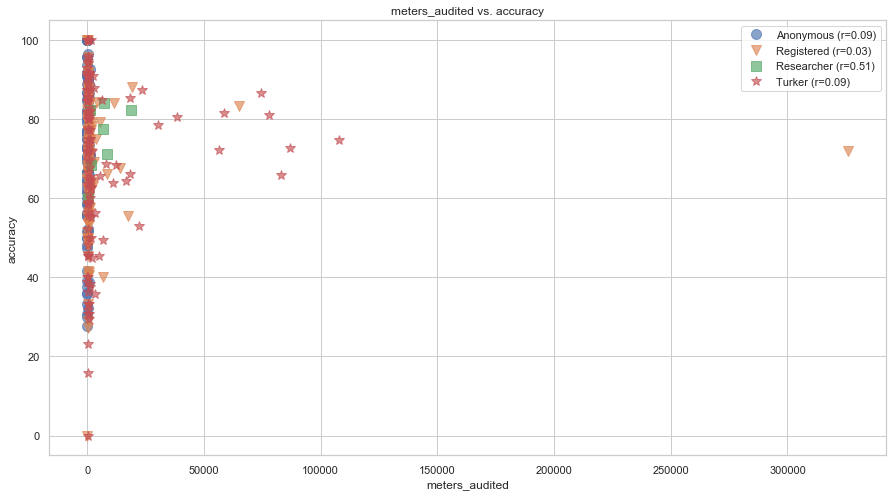

In [413]:
plot_scatter(df_users, 'meters_audited', 'accuracy');

# Accuracy as a function of role

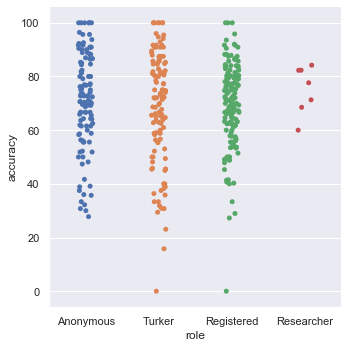

In [290]:
# from: https://seaborn.pydata.org/tutorial/categorical.html
# https://jakevdp.github.io/PythonDataScienceHandbook/04.14-visualization-with-seaborn.html
sns.catplot(x="role", y="accuracy", jitter=True, data=df_users);

,num_users,audit_mission_count,meters_audited,labels_total,validations_received_count,Avg Accuracy,Med Accuracy,SD Accuracy
role,,,,,,,,
Anonymous,112,189,3.358506e+04,2550,2612,71.083496,72.570533,17.910976
Registered,146,2102,5.682522e+05,26188,18338,69.539333,71.428571,15.582016
Researcher,7,168,4.441770e+04,3699,5576,75.187639,77.653004,8.939341
Turker,121,2911,8.379271e+05,53179,25198,69.080151,72.093023,20.808297
Total,386,5370,1.484182e+06,85616,51724,69.945870,72.073676,17.925156


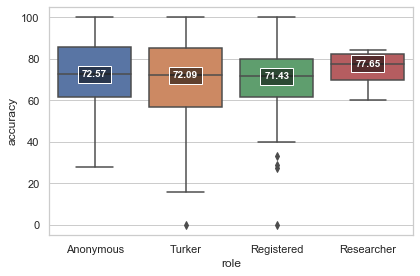

In [369]:
# https://seaborn.pydata.org/generated/seaborn.boxplot.html#seaborn.boxplot
sns.set_style("whitegrid")
# sns.catplot(x="role", y="accuracy", kind="box", data=df_users, height=6);
box_plot = sns.boxplot(x="role", y="accuracy", data=df_users)

# add in values
# from: https://stackoverflow.com/a/56879116
ax = box_plot.axes
lines = ax.get_lines()
categories = ax.get_xticks()

for cat in categories:
    # every 4th line at the interval of 6 is median line
    # 0 -> p25 1 -> p75 2 -> lower whisker 3 -> upper whisker 4 -> p50 5 -> upper extreme value
    y = round(lines[4+cat*6].get_ydata()[0], 2) 

    ax.text(cat, y, f'{y}', ha='center', va='center', fontweight='bold', 
        size=10, color='w', bbox=dict(facecolor='#00000088'))

box_plot.figure.tight_layout()
display_overview(df_users)

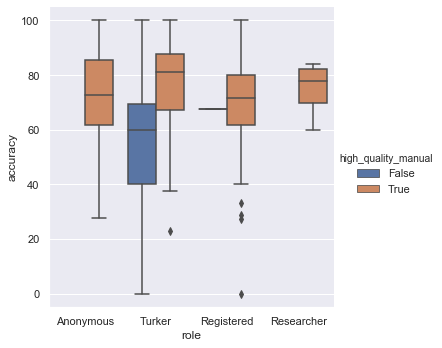

In [288]:
sns.catplot(x="role", y="accuracy", kind="box", hue='high_quality_manual', data=df_users);

## Histograms

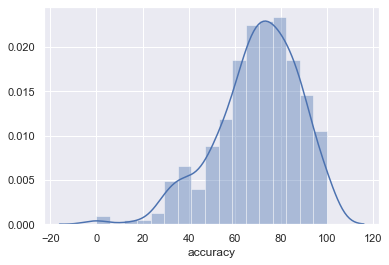

In [280]:
import seaborn as sns, numpy as np

ax = sns.distplot(df_users['accuracy'])

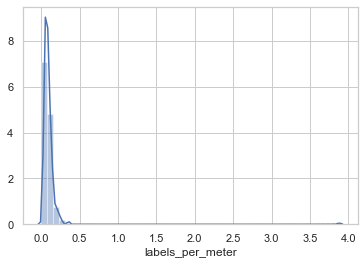

In [380]:
ax = sns.distplot(df_users['labels_per_meter'])

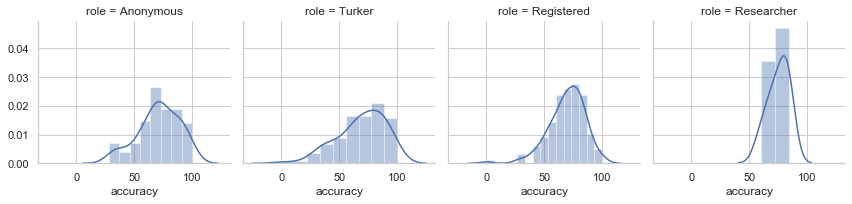

In [377]:
# https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/
g = sns.FacetGrid(df_users, row=None, col='role')
g.map(sns.distplot, "accuracy")
plt.show()

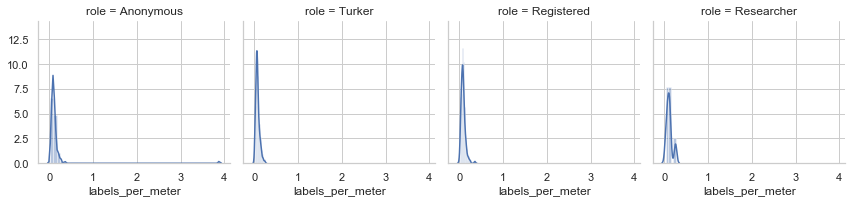

In [381]:
g = sns.FacetGrid(df_users, col='role')
g.map(sns.distplot, "labels_per_meter")

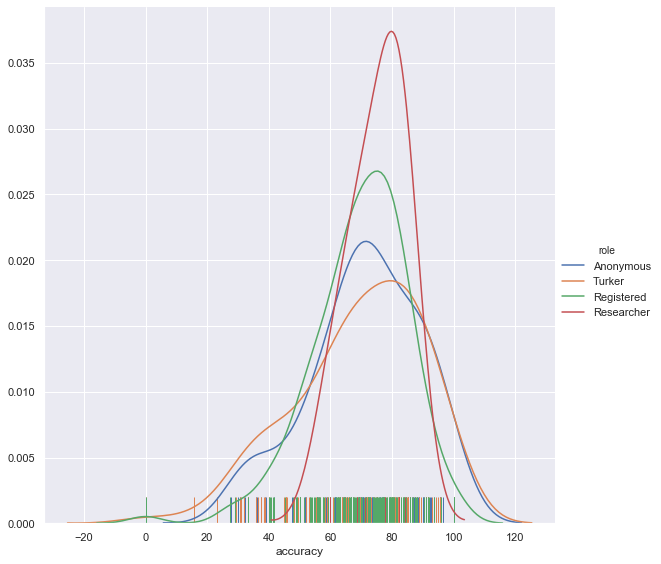

In [315]:
# fig, ax = plt.subplots(figsize=(10, 8))
g = sns.FacetGrid(df_users, hue="role", height=8)

g = g.map(sns.distplot, "accuracy",  hist=False, rug=True);
g.add_legend()

## Jointploints

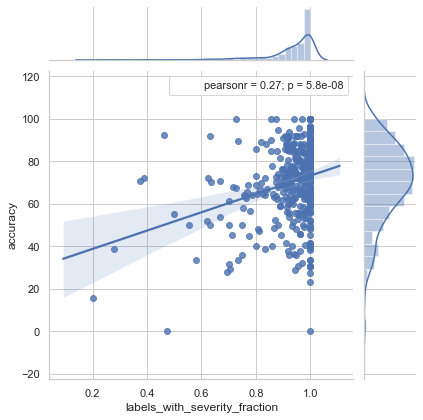

In [374]:
j = sns.jointplot(data=df_users, x='labels_with_severity_fraction', y='accuracy', kind='reg')
j.annotate(stats.pearsonr) # from: https://stackoverflow.com/a/52119784
plt.show()

C:\Users\jonfr\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


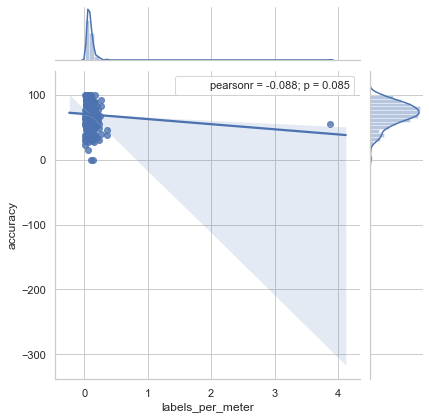

In [372]:
import scipy.stats as stats
j = sns.jointplot(data=df_users, x='labels_per_meter', y='accuracy', kind='reg')
j.annotate(stats.pearsonr)
plt.show()

# Predictions

In [427]:
# https://towardsdatascience.com/a-beginners-guide-to-linear-regression-in-python-with-scikit-learn-83a8f7ae2b4f

import pandas as pd  
import numpy as np  
import matplotlib.pyplot as plt  
import seaborn as seabornInstance 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression
from sklearn import metrics

# plot_scatter(df_users, 'curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][1])
# plot_scatter(df_users, 'missing_curb_ramps_with_severity_fraction', 'accuracy', ax = axes[0][2])
# plot_scatter(df_users, 'obstacles_with_severity_fraction', 'accuracy', ax = axes[1][0])
# plot_scatter(df_users, 'surface_problems_with_severity_fraction', 'accuracy', ax = axes[1][1])
# plot_scatter(df_users, 'no_sidewalks_with_severity_fraction', 'accuracy', ax = axes[1][2])


X = df_users[['labels_per_meter', 'labels_with_severity_fraction', 'missing_curb_ramps_with_severity_fraction',
              'obstacles_with_severity_fraction', 'surface_problems_with_severity_fraction', 
              'curb_ramps_with_severity_fraction', 'no_sidewalks_with_severity_fraction']]
y = df_users['accuracy'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
regressor = LinearRegression()  
regressor.fit(X_train, y_train)

coeff_df = pd.DataFrame(regressor.coef_, X.columns, columns=['Coefficient'])  
display(coeff_df)

y_pred = regressor.predict(X_test)
df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred})
display(df.sample(10))

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))  
#print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))  
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

,Coefficient
labels_per_meter,-8.882569
labels_with_severity_fraction,54.957282
missing_curb_ramps_with_severity_fraction,-9.614530
obstacles_with_severity_fraction,-9.690242
surface_problems_with_severity_fraction,-1.261667
curb_ramps_with_severity_fraction,-3.950663
no_sidewalks_with_severity_fraction,8.105662


,Actual,Predicted
0,81.061073,71.724062
19,41.509434,72.940777
73,27.777778,55.402535
10,80.000000,79.850758
29,81.318681,72.409123
71,74.074074,71.809565
68,83.673469,70.939036
2,70.967742,71.037030
38,66.223404,71.340501
52,73.529412,70.760932


Mean Absolute Error: 11.69898106462952
Root Mean Squared Error: 15.90127956142716


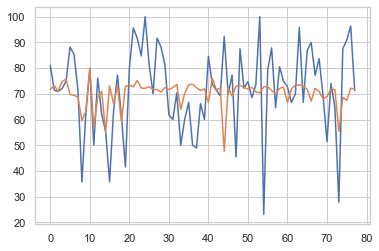

In [425]:
plt.plot(y_test)
plt.plot(y_pred)

# Sandbox

## Pairwise correlations

Text(0.5, 1, 'Pairwise correlation of input features')

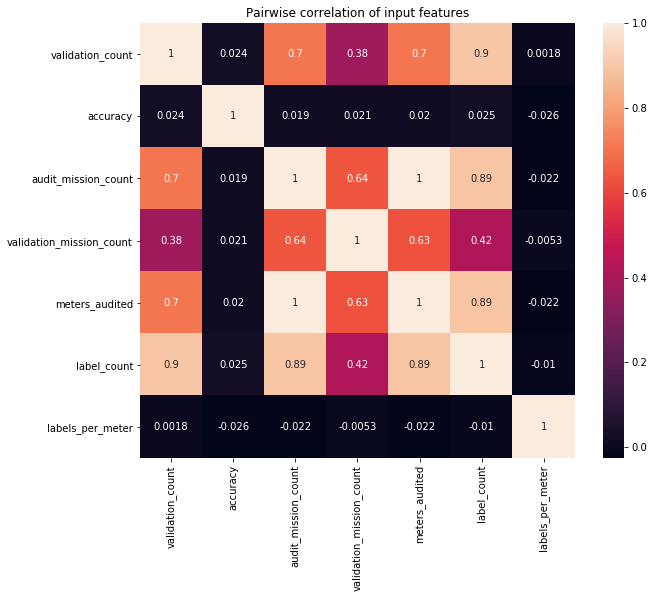

In [118]:
pairwise_corr = df_users.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(pairwise_corr, square=True, annot=True)
plt.title(f"Pairwise correlation of input features")

## Pairplots

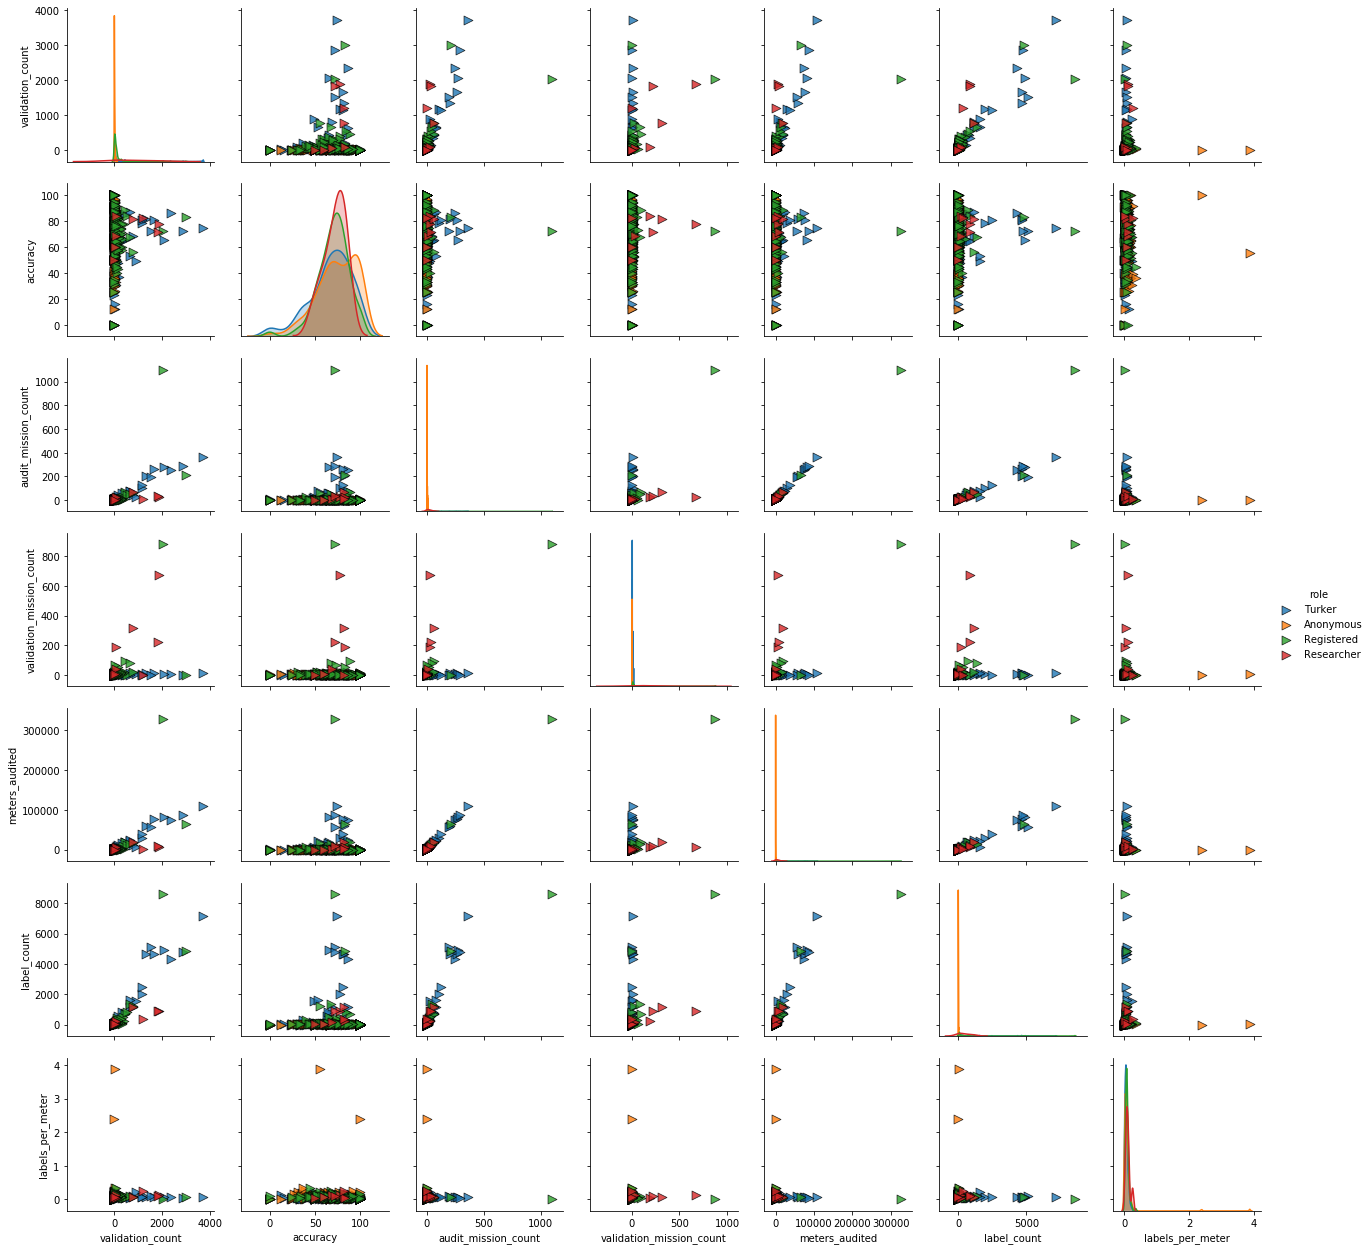

In [122]:
# Create the pairplot (this might take a bit of time)
markers = plot_markers[4]
sns.pairplot(df_users, hue="role", 
             plot_kws = {'alpha': 0.8, 's': 80, 'edgecolor': 'k'},
             markers = markers);